In [2]:
import pandas as pd
import numpy as np

In [4]:
#loading dataset
PATH = "/Users/binga17/Downloads/MSBA/3rd sem/Financial Analytics/Assignments/zomato.xlsx"   
df = pd.read_excel(PATH)


In [6]:
#cleaning 
def pick(colnames, *candidates):
    cand = [c for c in candidates if c in colnames]
    return cand[0] if cand else None

cols = list(df.columns)

col_votes = pick(cols, "votes", "Votes")
col_online = pick(cols, "online_order", "online_order?")
col_cost2 = pick(cols, "approx_cost(for two people)", "approx_cost(for two)", "cost_for_two")

In [8]:
# Convert to usable forms 
votes = pd.to_numeric(df[col_votes], errors="coerce") if col_votes else pd.Series(dtype=float)
cost2 = (df[col_cost2].astype(str).str.replace(",", "", regex=False) if col_cost2 else pd.Series(dtype=str))
cost2 = pd.to_numeric(cost2, errors="coerce")

if col_online:
    online = df[col_online].astype(str).str.lower().isin(["yes", "true", "1", "y"])
else:
    online = pd.Series([True]*len(df))  # if missing, just treat all rows as eligible

In [10]:
#simple demand calibration from data
online_votes = votes[online].dropna()
if len(online_votes) == 0:
    # fallback if dataset lacks online or votes
    high_votes_median = 50.0
    low_votes_median  = 40.0
    p_high = 0.55
else:
    # High demand = top quartile of votes
    thr = np.percentile(online_votes, 75)
    high_votes_median = float(online_votes[online_votes >= thr].median())
    low_votes_median  = float(online_votes[online_votes <  thr].median())
    # Probability of high demand = share of top-quartile restaurants
    p_high = (online_votes >= thr).mean()

# If anything degenerate, set reasonable defaults
if not np.isfinite(high_votes_median): high_votes_median = 100.0
if not np.isfinite(low_votes_median):  low_votes_median  = 40.0
if (not np.isfinite(p_high)) or (p_high < 0.05): p_high = 0.55

In [12]:
#translate votes -> orders
ORDERS_PER_QUARTER_PER_VOTE = 12
orders_high = high_votes_median * ORDERS_PER_QUARTER_PER_VOTE
orders_low  = low_votes_median  * ORDERS_PER_QUARTER_PER_VOTE

In [14]:
#basic economic assumptions

# Average order value (AOV) ~ half of "cost for two"
aov = (cost2.median()/2) if len(cost2.dropna()) else 12.0
if not np.isfinite(aov) or aov <= 0: aov = 12.0

MARGIN = 0.30             # base food margin
AGG_FEE = 0.20            # aggregator commission
INHOUSE_FIXED = 4000.0    # in-house fixed cost per quarter
BASELINE_NO_DELIVERY = 5000.0  # profit from dine-in/takeout only

# Per-order profit
profit_order_agg = aov * (MARGIN - AGG_FEE)     # after paying aggregator
profit_order_inh = aov * MARGIN                 # in-house keeps full margin

In [16]:
#payoffs by state

A_high = profit_order_agg * orders_high
A_low  = profit_order_agg * orders_low

B_high = profit_order_inh * orders_high - INHOUSE_FIXED
B_low  = profit_order_inh * orders_low  - INHOUSE_FIXED

C_high = BASELINE_NO_DELIVERY
C_low  = BASELINE_NO_DELIVERY

In [18]:
#expected values

p_low = 1 - p_high
EV_A = p_high*A_high + p_low*A_low
EV_B = p_high*B_high + p_low*B_low
EV_C = BASELINE_NO_DELIVERY  # constant

print("=== Inputs (easy to edit) ===")
print(f"AOV: ${aov:.2f} | Margin: {MARGIN:.0%} | Agg fee: {AGG_FEE:.0%} | In-house fixed: ${INHOUSE_FIXED:,.0f}")
print(f"Orders (High, Low): {orders_high:.0f}, {orders_low:.0f} | p_high: {p_high:.2f}\n")

print("=== Payoffs by state (per quarter) ===")
print(f"A (Aggregator): High=${A_high:,.0f}, Low=${A_low:,.0f}")
print(f"B (In-house):  High=${B_high:,.0f}, Low=${B_low:,.0f}")
print(f"C (No delivery): High=${C_high:,.0f}, Low=${C_low:,.0f}\n")

print("=== Expected Values (EV) ===")
print(f"EV(Aggregator) = ${EV_A:,.0f}")
print(f"EV(In-house)   = ${EV_B:,.0f}")
print(f"EV(No delivery) = ${EV_C:,.0f}")


=== Inputs (easy to edit) ===
AOV: $12.00 | Margin: 30% | Agg fee: 20% | In-house fixed: $4,000
Orders (High, Low): 600, 480 | p_high: 0.55

=== Payoffs by state (per quarter) ===
A (Aggregator): High=$720, Low=$576
B (In-house):  High=$-1,840, Low=$-2,272
C (No delivery): High=$5,000, Low=$5,000

=== Expected Values (EV) ===
EV(Aggregator) = $655
EV(In-house)   = $-2,034
EV(No delivery) = $5,000


In [22]:
#recommendation by EV
best = max([("Aggregator (A)", EV_A), ("In-house (B)", EV_B), ("No delivery (C)", EV_C)], key=lambda x: x[1])
print(f"\n>>> EV-Optimal Strategy: {best[0]} (${best[1]:,.0f})")


>>> EV-Optimal Strategy: No delivery (C) ($5,000)


In [24]:
#Tiny sensitivity tests (1) change p_high, (2) change a payoff parameter

def expected_values(p_hi, agg_fee=AGG_FEE, in_fixed=INHOUSE_FIXED):
    prof_agg = aov * (MARGIN - agg_fee)
    prof_inh = aov * MARGIN
    A_hi, A_lo = prof_agg*orders_high, prof_agg*orders_low
    B_hi, B_lo = prof_inh*orders_high - in_fixed, prof_inh*orders_low - in_fixed
    C = BASELINE_NO_DELIVERY
    p_lo = 1 - p_hi
    EV_A = p_hi*A_hi + p_lo*A_lo
    EV_B = p_hi*B_hi + p_lo*B_lo
    EV_C = C
    return EV_A, EV_B, EV_C

print("\n=== Sensitivity: p_high from 0.30 to 0.80 (step=0.10) ===")
for p in np.arange(0.30, 0.81, 0.10):
    eA, eB, eC = expected_values(p)
    winner = max([("A", eA), ("B", eB), ("C", eC)], key=lambda x: x[1])[0]
    print(f"p_high={p:0.2f} -> EV_A=${eA:,.0f}, EV_B=${eB:,.0f}, EV_C=${eC:,.0f} | Best={winner}")

print("\n=== Sensitivity: Aggregator fee +5 percentage points ===")
eA, eB, eC = expected_values(p_high, agg_fee=AGG_FEE+0.05)
print(f"EVs -> A=${eA:,.0f}, B=${eB:,.0f}, C=${eC:,.0f}")

print("\n=== Sensitivity: In-house fixed cost +$2,000 ===")
eA, eB, eC = expected_values(p_high, in_fixed=INHOUSE_FIXED+2000)
print(f"EVs -> A=${eA:,.0f}, B=${eB:,.0f}, C=${eC:,.0f}")


=== Sensitivity: p_high from 0.30 to 0.80 (step=0.10) ===
p_high=0.30 -> EV_A=$619, EV_B=$-2,142, EV_C=$5,000 | Best=C
p_high=0.40 -> EV_A=$634, EV_B=$-2,099, EV_C=$5,000 | Best=C
p_high=0.50 -> EV_A=$648, EV_B=$-2,056, EV_C=$5,000 | Best=C
p_high=0.60 -> EV_A=$662, EV_B=$-2,013, EV_C=$5,000 | Best=C
p_high=0.70 -> EV_A=$677, EV_B=$-1,970, EV_C=$5,000 | Best=C
p_high=0.80 -> EV_A=$691, EV_B=$-1,926, EV_C=$5,000 | Best=C

=== Sensitivity: Aggregator fee +5 percentage points ===
EVs -> A=$328, B=$-2,034, C=$5,000

=== Sensitivity: In-house fixed cost +$2,000 ===
EVs -> A=$655, B=$-4,034, C=$5,000


In [26]:
import matplotlib.pyplot as plt

In [28]:
p_high = 0.55
AOV = 12.0           # average order value
MARGIN = 0.30
AGG_FEE = 0.20
INHOUSE_FIXED = 4000.0
BASELINE_NO_DELIVERY = 5000.0
ORDERS_HIGH = 600
ORDERS_LOW  = 600

In [42]:
# Payoffs
profit_order_agg = AOV * (MARGIN - AGG_FEE)
profit_order_inh = AOV * MARGIN

A_high = profit_order_agg * ORDERS_HIGH
A_low  = profit_order_agg * ORDERS_LOW
B_high = profit_order_inh * ORDERS_HIGH - INHOUSE_FIXED
B_low  = profit_order_inh * ORDERS_LOW  - INHOUSE_FIXED
C_pay  = BASELINE_NO_DELIVERY

EV_A = p_high*A_high + (1-p_high)*A_low
EV_B = p_high*B_high + (1-p_high)*B_low
EV_C = C_pay


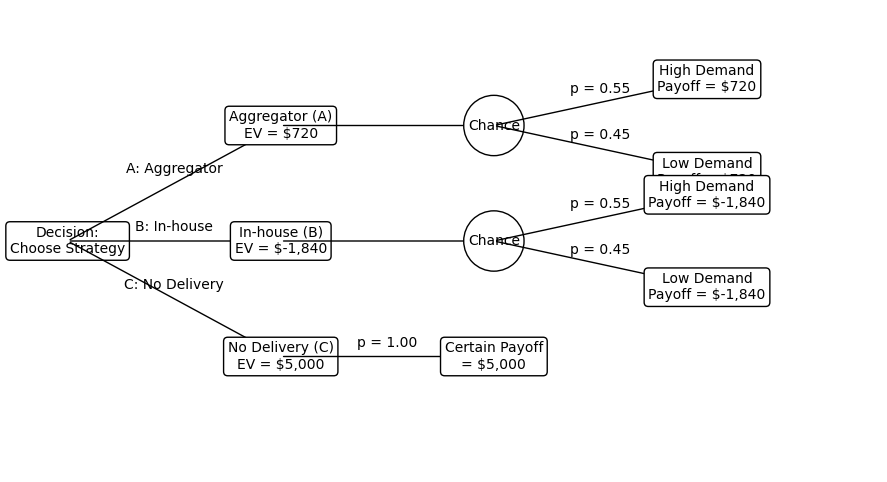

In [50]:
# --- Layout positions ---
root = (0.05, 0.5)
A_node = (0.30, 0.75)
B_node = (0.30, 0.50)
C_node = (0.30, 0.25)
A_chance = (0.55, 0.75)
B_chance = (0.55, 0.50)
A_high_leaf = (0.80, 0.85)
A_low_leaf  = (0.80, 0.65)
B_high_leaf = (0.80, 0.60)
B_low_leaf  = (0.80, 0.40)
C_leaf      = (0.55, 0.25)

def draw_node(ax, text, xy, boxstyle="round", fc="white", ec="black"):
    ax.annotate(text, xy=xy, xycoords='axes fraction',
                ha='center', va='center',
                bbox=dict(boxstyle=boxstyle, fc=fc, ec=ec))

def draw_arrow(ax, start, end, text=None):
    ax.annotate("", xy=end, xycoords='axes fraction',
                xytext=start, textcoords='axes fraction',
                arrowprops=dict(arrowstyle="->"))
    if text:
        mx = (start[0] + end[0]) / 2
        my = (start[1] + end[1]) / 2
        ax.text(mx, my+0.03, text, transform=ax.transAxes, ha="center", va="center")

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(111)
ax.set_axis_off()

draw_node(ax, "Decision:\nChoose Strategy", root, boxstyle="round,pad=0.3")

draw_arrow(ax, root, A_node, "A: Aggregator")
draw_arrow(ax, root, B_node, "B: In-house")
draw_arrow(ax, root, C_node, "C: No Delivery")

draw_node(ax, f"Aggregator (A)\nEV = ${EV_A:,.0f}", A_node, boxstyle="round,pad=0.3")
draw_node(ax, f"In-house (B)\nEV = ${EV_B:,.0f}",  B_node, boxstyle="round,pad=0.3")
draw_node(ax, f"No Delivery (C)\nEV = ${EV_C:,.0f}", C_node, boxstyle="round,pad=0.3")

draw_arrow(ax, A_node, A_chance)
draw_arrow(ax, B_node, B_chance)
draw_node(ax, "Chance", A_chance, boxstyle="circle,pad=0.3")
draw_node(ax, "Chance", B_chance, boxstyle="circle,pad=0.3")

draw_arrow(ax, A_chance, A_high_leaf, f"p = {p_high:.2f}")
draw_arrow(ax, A_chance, A_low_leaf,  f"p = {1-p_high:.2f}")
draw_node(ax, f"High Demand\nPayoff = ${A_high:,.0f}", A_high_leaf, boxstyle="round,pad=0.3")
draw_node(ax, f"Low Demand\nPayoff = ${A_low:,.0f}",  A_low_leaf,  boxstyle="round,pad=0.3")

draw_arrow(ax, B_chance, B_high_leaf, f"p = {p_high:.2f}")
draw_arrow(ax, B_chance, B_low_leaf,  f"p = {1-p_high:.2f}")
draw_node(ax, f"High Demand\nPayoff = ${B_high:,.0f}", B_high_leaf, boxstyle="round,pad=0.3")
draw_node(ax, f"Low Demand\nPayoff = ${B_low:,.0f}",  B_low_leaf,  boxstyle="round,pad=0.3")

draw_arrow(ax, C_node, C_leaf, "p = 1.00")
draw_node(ax, f"Certain Payoff\n= ${C_pay:,.0f}", C_leaf, boxstyle="round,pad=0.3")


